In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [47]:
match_info = pd.read_csv("./data/match_info.csv")
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [48]:
match_info.head()

,game_id,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,competition_name,country_name,season_name,home_team_name,home_team_name_ko,away_team_name,away_team_name_ko
0,126283,3669,587,1,2024-03-01 05:00:00,2354,4639,1,0,문수월드컵경기장,K League 1,KR,2024,Ulsan HD FC,울산 HD FC,Pohang Steelers,포항 스틸러스
1,126284,3669,587,1,2024-03-01 07:30:00,4640,4657,1,1,전주월드컵경기장,K League 1,KR,2024,Jeonbuk Hyundai Motors,전북 현대 모터스,Daejeon Hana Citizen,대전 하나 시티즌
2,126285,3669,587,1,2024-03-02 05:00:00,4648,316,2,0,광주전용구장,K League 1,KR,2024,Gwangju FC,광주FC,FC Seoul,FC서울
3,126286,3669,587,1,2024-03-02 07:30:00,4646,4220,0,1,인천축구전용경기장,K League 1,KR,2024,Incheon United,인천 유나이티드,Suwon FC,수원FC
4,126287,3669,587,1,2024-03-02 07:30:00,4643,4641,1,1,송암스포츠타운 주경기장,K League 1,KR,2024,Gangwon FC,강원FC,Jeju United,제주SK FC


In [49]:
train.head()

,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,start_y,end_x,end_y,is_home,game_episode
0,126283,1,1,0.667,2354,344559,0,Pass,Successful,52.418205,33.485444,31.322445,38.274752,True,126283_1
1,126283,1,1,3.667,2354,250036,2,Pass,Successful,32.013240,38.100808,37.371285,30.632980,True,126283_1
2,126283,1,1,4.968,2354,500145,4,Carry,NaN,37.371285,30.632980,38.391570,24.613144,True,126283_1
3,126283,1,1,8.200,2354,500145,5,Pass,Successful,38.391570,24.613144,34.573350,5.545468,True,126283_1
4,126283,1,1,11.633,2354,142106,7,Pass,Successful,34.578705,6.058256,21.274470,18.437112,True,126283_1


=== 팀별 전술 분석 결과 (상위 5개 팀) ===
   team_id  mean_episode_len  mean_location_x      Left     Center     Right
0      316        277.081081        47.306056  2.702703  95.495495  1.801802
1     2353        255.652174        49.026247  0.869565  98.260870  0.869565
2     2354        310.886792        48.863612  2.830189  93.396226  3.773585
3     4220        273.990909        48.197363  0.909091  97.272727  1.818182
4     4639        290.752381        46.893503  2.857143  96.190476  0.952381


<Figure size 1200x600 with 0 Axes>

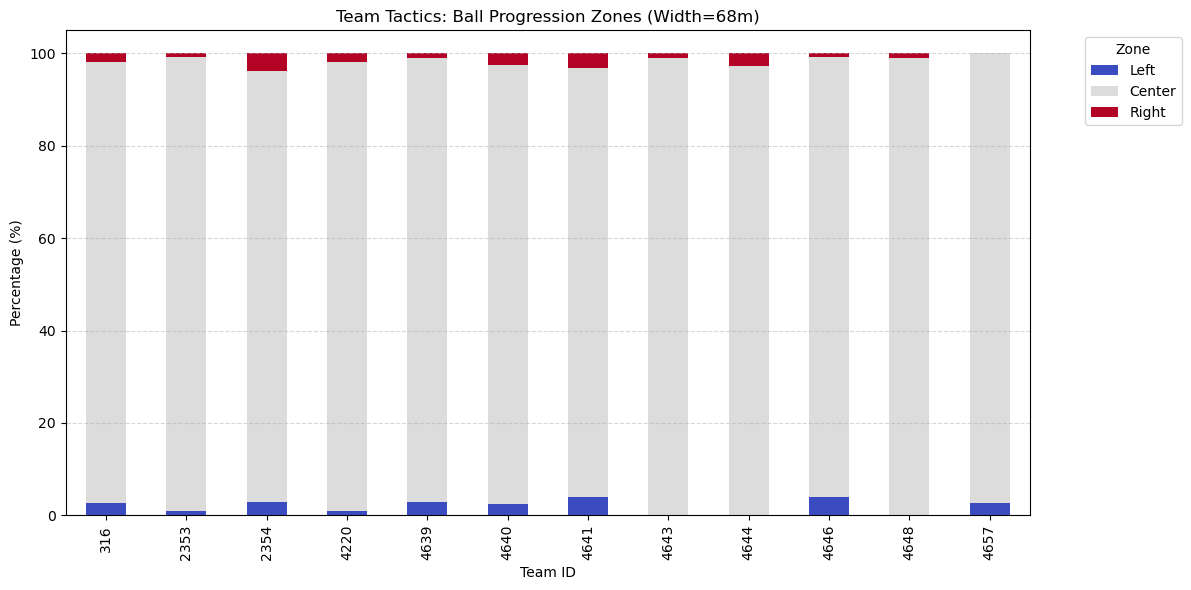

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 에피소드별 통계 계산
episode_stats = train.groupby(['team_id', 'episode_id']).agg(
    episode_length=('start_x', 'size'),          # 에피소드 길이 (이벤트 수)
    avg_start_x=('start_x', 'mean'),             # 평균 X 위치
    avg_start_y=('start_y', 'mean'),             # 평균 Y 위치
    avg_end_x=('end_x', 'mean'),
    avg_end_y=('end_y', 'mean')
).reset_index()

# 3. 공 전개 위치(Zone) 분류 로직 (68m 규격 기준 적용)
# 경기장 폭 68m를 3등분
# Left: 0 ~ 22.67m
# Center: 22.67 ~ 45.33m
# Right: 45.33 ~ 68m
def classify_zone(y):
    if y < 22.67:
        return 'Left'
    elif y < 45.33:
        return 'Center'
    else:
        return 'Right'

# 에피소드 평균 Y좌표 계산 및 Zone 할당
episode_stats['avg_y'] = (episode_stats['avg_start_y'] + episode_stats['avg_end_y']) / 2
episode_stats['zone'] = episode_stats['avg_y'].apply(classify_zone)

# 4. 팀별 전술 집계
# 4-1. 평균 수치 계산
team_stats = episode_stats.groupby('team_id').agg(
    mean_episode_len=('episode_length', 'mean'),  # 평균 패스/이벤트 연결 횟수
    mean_location_x=('avg_start_x', 'mean')       # 평균 라인 높이 (전진성)
)

# 4-2. Zone 비율 계산 (KeyError 방지를 위해 안전한 방식 사용)
# normalize='index'로 행별 합이 1이 되도록 계산 후 100을 곱해 %로 변환
zone_ratios = pd.crosstab(episode_stats['team_id'], episode_stats['zone'], normalize='index') * 100

# [중요] 특정 구역 데이터가 없을 경우를 대비해 컬럼을 강제로 맞춤
desired_columns = ['Left', 'Center', 'Right']
zone_ratios = zone_ratios.reindex(columns=desired_columns, fill_value=0)

# 5. 최종 데이터 병합
final_analysis = pd.merge(team_stats, zone_ratios, left_index=True, right_index=True).reset_index()

print("=== 팀별 전술 분석 결과 (상위 5개 팀) ===")
print(final_analysis)

# 6. 시각화
# 6-1. 팀별 공격 방향 비율 (Stacked Bar Chart)
plt.figure(figsize=(12, 6))
plot_data = final_analysis.set_index('team_id')[['Left', 'Center', 'Right']]
plot_data.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))

plt.title("Team Tactics: Ball Progression Zones (Width=68m)")
plt.ylabel("Percentage (%)")
plt.xlabel("Team ID")
plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

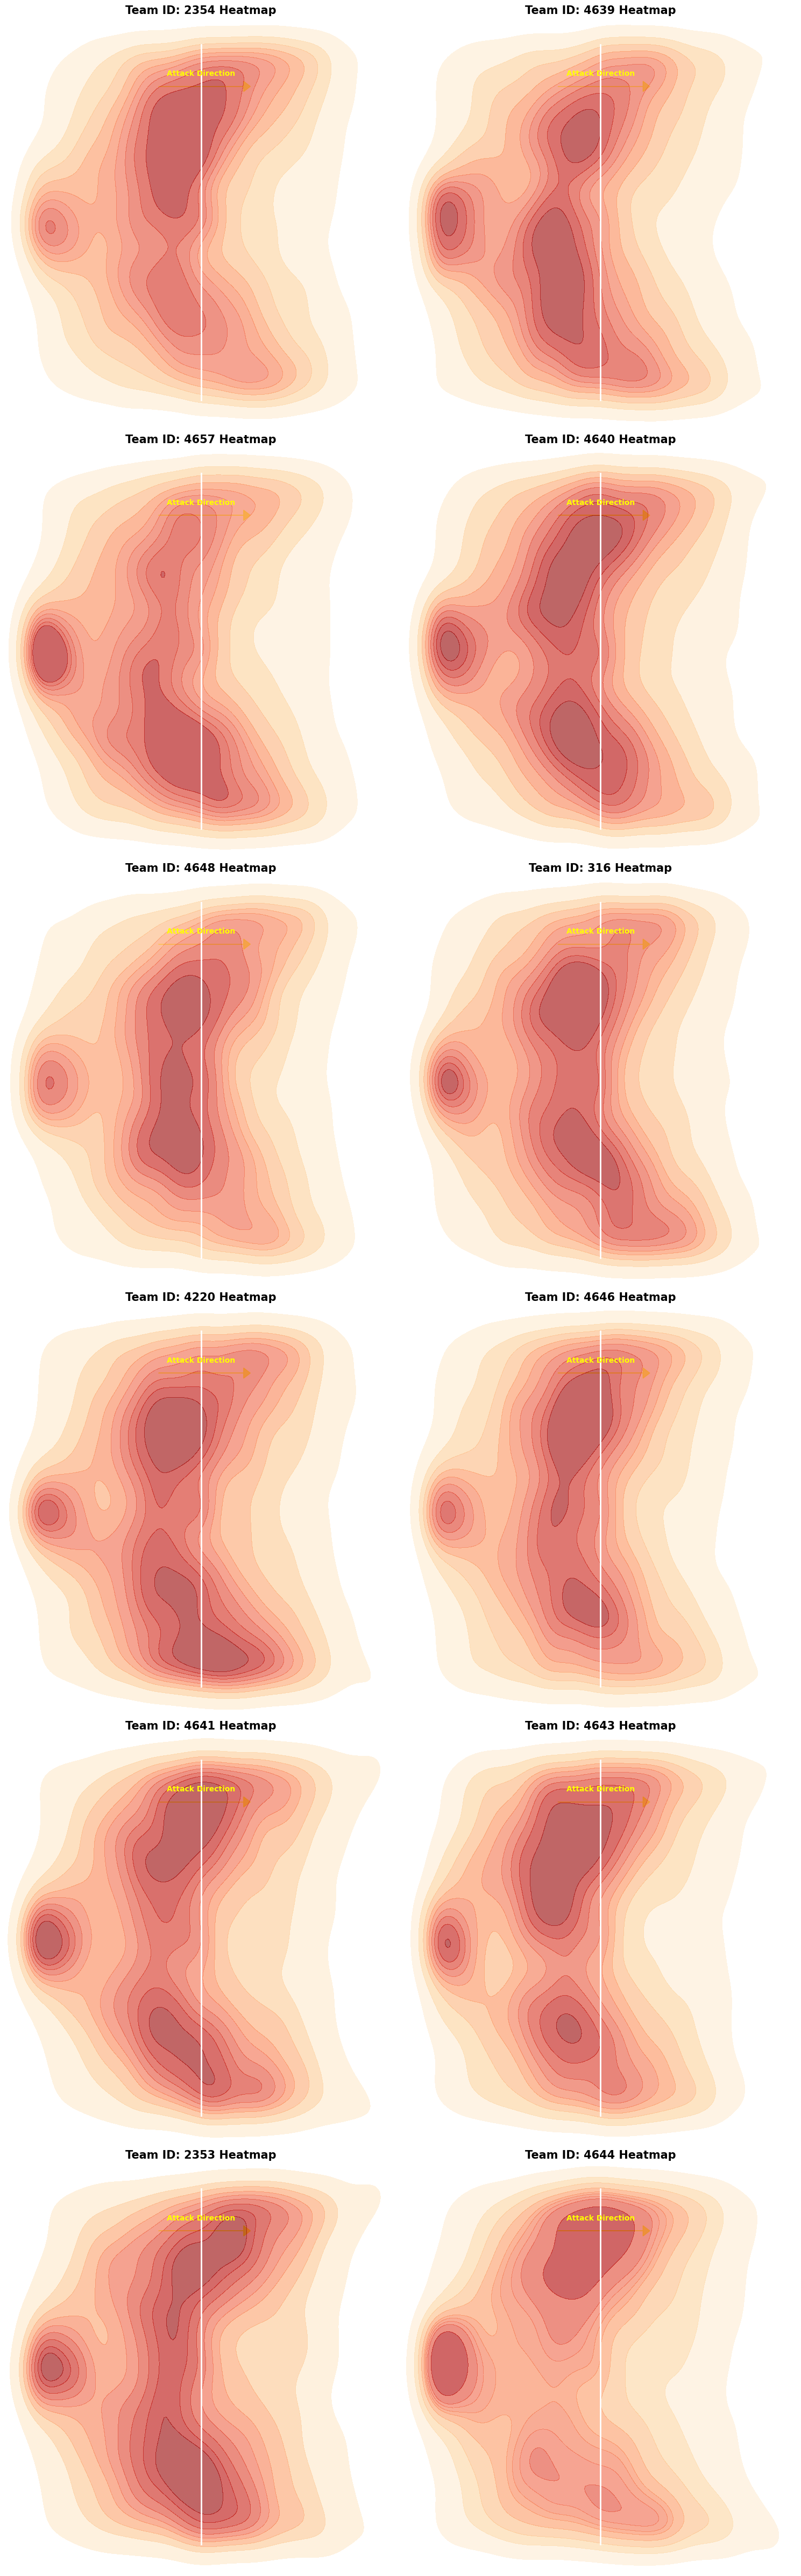

In [51]:
import matplotlib.patches as patches

# 1. 축구장 배경을 그리는 함수 (재사용 목적)
def draw_pitch(ax):
    # 경기장 외곽선 (Green Background)
    ax.set_facecolor('#247d28') # 잔디색
    
    # 경기장 라인 그리기 (흰색)
    # 외곽선
    ax.add_patch(patches.Rectangle((0, 0), 105, 68, fill=False, edgecolor='white', linewidth=2))
    # 중앙선
    ax.plot([52.5, 52.5], [0, 68], color='white', linewidth=2)
    # 센터 서클
    ax.add_patch(patches.Circle((52.5, 34), 9.15, fill=False, edgecolor='white', linewidth=2))
    # 중앙 점
    ax.add_patch(patches.Circle((52.5, 34), 0.5, fill=True, color='white'))
    
    # 페널티 박스 (좌측/우측) - 대략적인 규격 적용 (16.5m 깊이)
    # Left Penalty Area
    ax.add_patch(patches.Rectangle((0, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    # Right Penalty Area
    ax.add_patch(patches.Rectangle((105-16.5, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    
    # 골대 (선택 사항)
    # Left Goal
    ax.add_patch(patches.Rectangle((-2, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))
    # Right Goal
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))

    # 공격 방향 화살표 표시 (L -> R)
    ax.arrow(40, 60, 25, 0, head_width=2, head_length=2, fc='yellow', ec='yellow', alpha=0.7)
    ax.text(52.5, 62, "Attack Direction", color='yellow', ha='center', fontsize=10, fontweight='bold')

# 2. 팀 리스트 가져오기 (데이터 양이 많으면 상위 N개 팀만 선택하세요)
unique_teams = train['team_id'].unique()
# 예시: 상위 6개 팀만 시각화 (전체를 보려면 [:6] 제거)
target_teams = unique_teams

# 3. 시각화 실행 (Subplots 활용)
# 한 줄에 2개씩 배치
cols = 2
rows = (len(target_teams) + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 8))
axes = axes.flatten()

for i, team_id in enumerate(target_teams):
    ax = axes[i]
    
    # 3-1. 경기장 그리기
    draw_pitch(ax)
    
    # 3-2. 해당 팀 데이터 필터링
    team_data = train[train['team_id'] == team_id]
    
    # 3-3. 히트맵(KDE Plot) 그리기
    # cmap: 'OrRd' (주황-빨강), 'Hot' (검정-빨강-노랑), 'Greys' 등 변경 가능
    sns.kdeplot(
        data=team_data,
        x='start_x',
        y='start_y',
        fill=True,
        cmap='OrRd',       # 붉은색 계열 히트맵
        thresh=0.05,       # 하위 5% 밀도(노이즈) 숨김
        alpha=0.6,         # 투명도
        levels=10,         # 등고선 단계 수
        ax=ax
    )
    
    # 3-4. 그래프 꾸미기
    ax.set_title(f"Team ID: {team_id} Heatmap", fontsize=15, fontweight='bold', color='black')
    ax.set_xlim(-5, 110) # 경기장보다 조금 넓게
    ax.set_ylim(-5, 73)
    ax.set_xlabel("Length (m)")
    ax.set_ylabel("Width (m)")
    ax.axis('off') # 축 눈금 숨기기 (경기장 느낌 강조)

# 남는 subplot이 있다면 끄기
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
# train = pd.read_csv("./data/train.csv") # 이미 로드되어 있다면 주석 처리

# 2. 에피소드별 통계 계산 (is_home 추가)
# team_id와 함께 is_home을 그룹화 키로 추가하여 홈/원정 상태를 유지합니다.
episode_stats = train.groupby(['team_id', 'is_home', 'episode_id']).agg(
    episode_length=('start_x', 'size'),          # 에피소드 길이 (이벤트 수)
    avg_start_x=('start_x', 'mean'),             # 평균 X 위치
    avg_start_y=('start_y', 'mean'),             # 평균 Y 위치
    avg_end_x=('end_x', 'mean'),
    avg_end_y=('end_y', 'mean')
).reset_index()

# 3. 공 전개 위치(Zone) 분류 로직 (68m 규격 기준)
def classify_zone(y):
    if y < 22.67:
        return 'Left'
    elif y < 45.33:
        return 'Center'
    else:
        return 'Right'

# 에피소드 평균 Y좌표 계산 및 Zone 할당
episode_stats['avg_y'] = (episode_stats['avg_start_y'] + episode_stats['avg_end_y']) / 2
episode_stats['zone'] = episode_stats['avg_y'].apply(classify_zone)

# 4. 팀별 & 홈/원정별 전술 집계
# 4-1. 평균 수치 계산 (groupby에 is_home 포함)
team_stats = episode_stats.groupby(['team_id', 'is_home']).agg(
    mean_episode_len=('episode_length', 'mean'),  # 평균 패스/이벤트 연결 횟수
    mean_location_x=('avg_start_x', 'mean')       # 평균 라인 높이 (전진성)
)

# 4-2. Zone 비율 계산
# 인덱스가 (team_id, is_home)인 상태로 crosstab 생성
zone_ratios = pd.crosstab(
    [episode_stats['team_id'], episode_stats['is_home']], 
    episode_stats['zone'], 
    normalize='index'
) * 100

# 특정 구역 데이터가 없을 경우를 대비해 컬럼 강제 맞춤
desired_columns = ['Left', 'Center', 'Right']
zone_ratios = zone_ratios.reindex(columns=desired_columns, fill_value=0)

# 5. 최종 데이터 병합
# 인덱스(team_id, is_home)를 기준으로 병합
final_analysis = pd.merge(team_stats, zone_ratios, left_index=True, right_index=True).reset_index()

# 시각화를 위해 라벨 생성 (예: TeamA (Home), TeamA (Away))
final_analysis['label'] = final_analysis.apply(
    lambda x: f"{x['team_id']} ({'Home' if x['is_home'] else 'Away'})", axis=1
)

print("=== 팀별/홈원정별 전술 분석 결과 (상위 5개 행) ===")
print(final_analysis)

# 6. 시각화
# 6-1. 팀별 공격 방향 비율 (Stacked Bar Chart)
plt.figure(figsize=(14, 6))

# X축을 'label'로 설정하여 홈/원정 구분
plot_data = final_analysis.set_index('label')[['Left', 'Center', 'Right']]

# 데이터가 너무 많으면 상위 20개만 시각화 (선택 사항)
if len(plot_data) > 20:
    plot_data = plot_data.head(20)

plot_data.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 6))

plt.title("Team Tactics by Venue: Ball Progression Zones")
plt.ylabel("Percentage (%)")
plt.xlabel("Team (Venue)")
plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right') # 라벨 회전
plt.tight_layout()
plt.show()

NameError: name 'train' is not defined

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

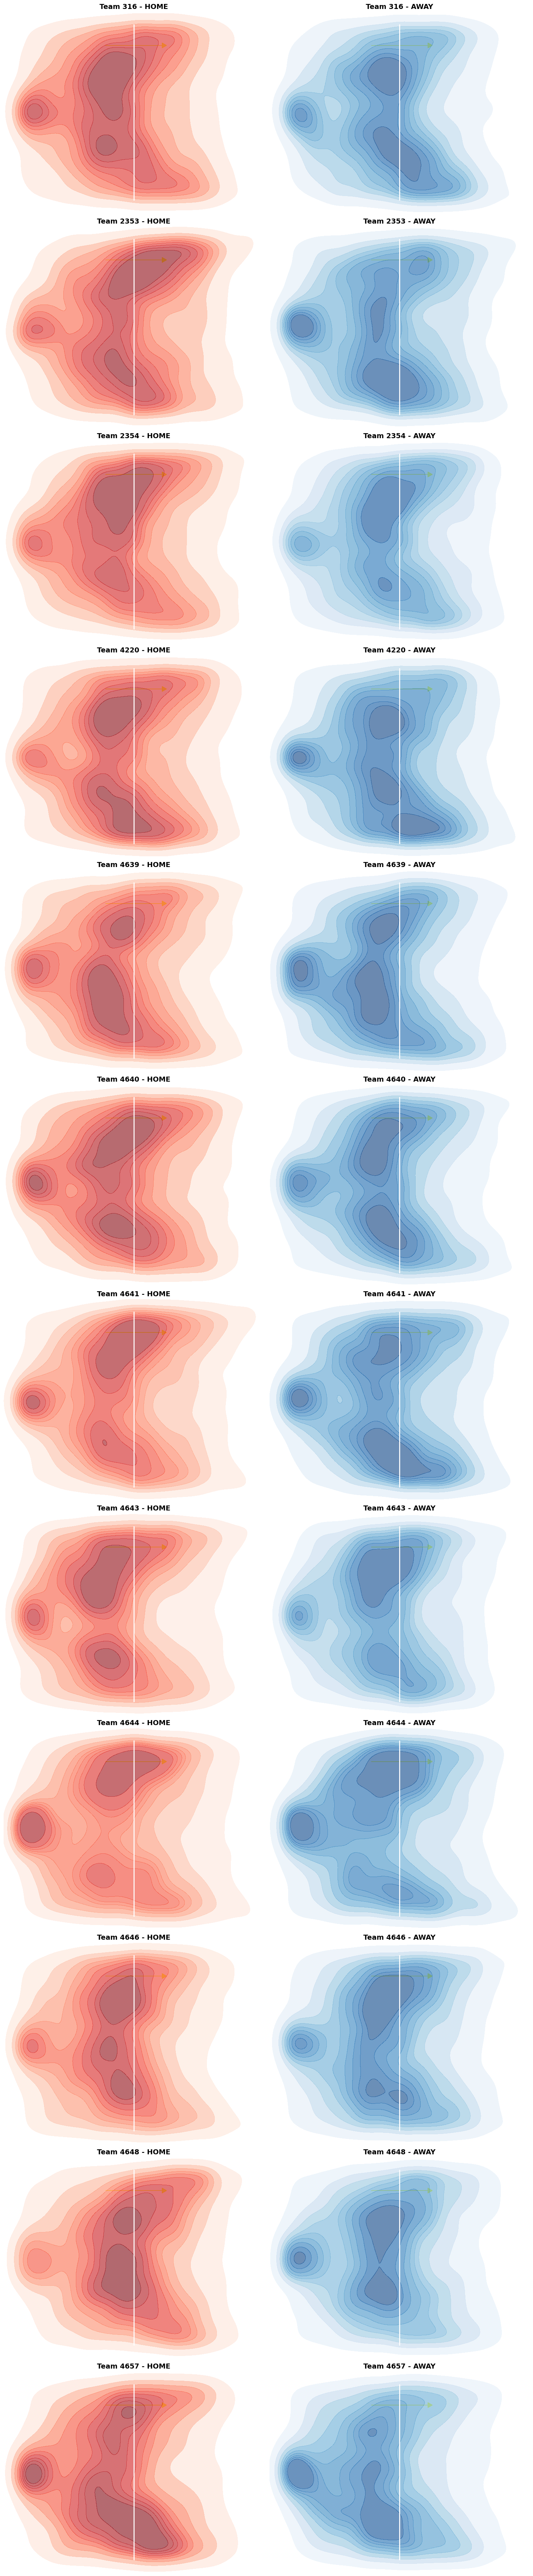

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math

# 1. 축구장 배경을 그리는 함수 (동일)
def draw_pitch(ax):
    ax.set_facecolor('#247d28') # 잔디색
    
    # 경기장 외곽선 및 라인
    ax.add_patch(patches.Rectangle((0, 0), 105, 68, fill=False, edgecolor='white', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='white', linewidth=2)
    ax.add_patch(patches.Circle((52.5, 34), 9.15, fill=False, edgecolor='white', linewidth=2))
    ax.add_patch(patches.Circle((52.5, 34), 0.5, fill=True, color='white'))
    
    # 페널티 박스
    ax.add_patch(patches.Rectangle((0, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    ax.add_patch(patches.Rectangle((105-16.5, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    
    # 골대
    ax.add_patch(patches.Rectangle((-2, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))

    # 공격 방향 화살표
    ax.arrow(40, 60, 25, 0, head_width=2, head_length=2, fc='yellow', ec='yellow', alpha=0.7)

# 2. 분석 대상 팀 설정
# 팀 ID 순으로 정렬 (비교를 위해)
unique_teams = sorted(train['team_id'].unique())
target_teams = unique_teams

# 3. 시각화 실행 (Row: 팀, Col: 홈/원정)
rows = len(target_teams)
cols = 2 # 왼쪽: Home, 오른쪽: Away

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 6))

# 데이터가 1개 팀(1행)일 경우 axes가 1차원 배열이 되므로 2차원으로 변환
if rows == 1:
    axes = axes.reshape(1, -1)

for i, team_id in enumerate(target_teams):
    # 홈(True)과 원정(False) 순회
    for j, is_home in enumerate([True, False]):
        ax = axes[i, j]
        
        # 3-1. 경기장 그리기
        draw_pitch(ax)
        
        # 3-2. 데이터 필터링 (팀 AND 홈/원정)
        team_data = train[(train['team_id'] == team_id) & (train['is_home'] == is_home)]
        
        # 데이터가 존재하는 경우에만 그리기
        if not team_data.empty:
            # 3-3. 히트맵 그리기
            # 홈: 붉은색(Reds), 원정: 파란색(Blues)
            cmap_color = 'Reds' if is_home else 'Blues'
            
            sns.kdeplot(
                data=team_data,
                x='start_x',
                y='start_y',
                fill=True,
                cmap=cmap_color,
                thresh=0.05,
                alpha=0.6,
                levels=10,
                ax=ax
            )
        
        # 3-4. 그래프 타이틀 및 스타일 설정
        match_type = "HOME" if is_home else "AWAY"
        ax.set_title(f"Team {team_id} - {match_type}", fontsize=14, fontweight='bold', color='black')
        
        ax.set_xlim(-5, 110)
        ax.set_ylim(-5, 73)
        ax.axis('off') # 축 숨기기

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

=== 팀별 에피소드 마지막 위치(Finishing) 분석 ===
   team_id  mean_finish_x  mean_finish_y       Left     Center      Right
0      316      48.222337      33.771380  29.729730  35.135135  35.135135
1     2353      56.946725      32.750926  38.260870  25.217391  36.521739
2     2354      46.121241      38.944657  24.528302  28.301887  47.169811
3     4220      56.473678      34.880063  33.636364  29.090909  37.272727
4     4639      52.097475      33.251869  37.142857  27.619048  35.238095


<Figure size 1200x600 with 0 Axes>

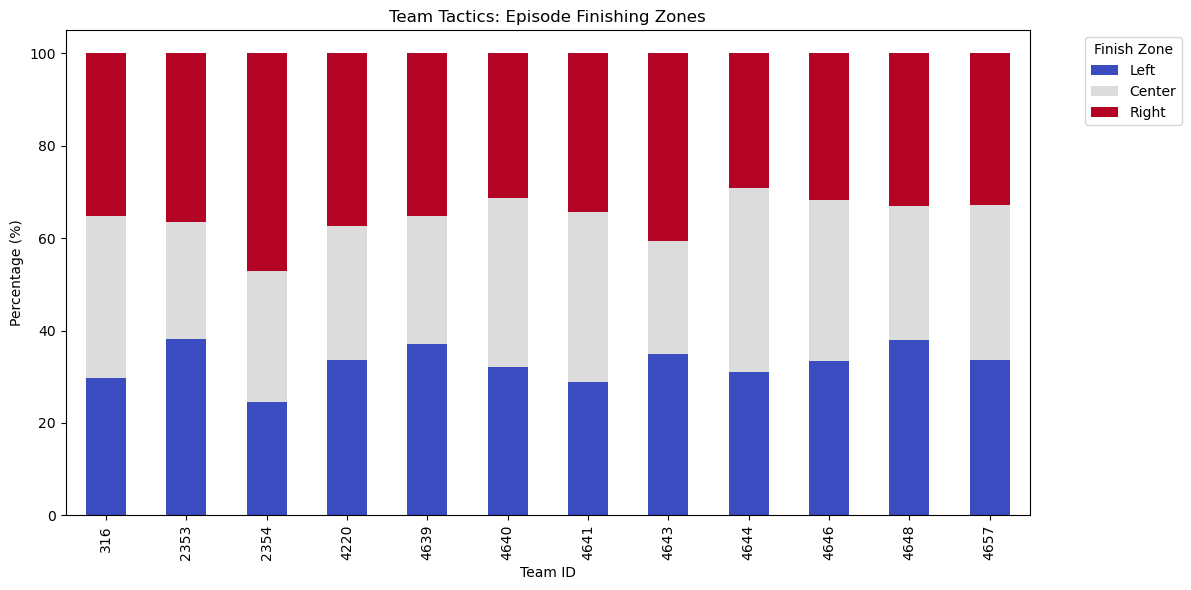

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 (이미 로드되어 있다면 생략)
# train = pd.read_csv("./data/train.csv")

# 2. 에피소드별 '마지막' 위치 데이터 추출
# 'last' 함수를 사용하여 각 그룹의 마지막 행(이벤트)의 좌표를 가져옵니다.
episode_finish_stats = train.groupby(['team_id', 'episode_id']).agg(
    finish_x=('start_x', 'last'),  # 마지막 이벤트의 시작 X좌표 (마무리 위치)
    finish_y=('start_y', 'last')   # 마지막 이벤트의 시작 Y좌표
).reset_index()

# 3. 마무리 위치(Zone) 분류 (경기장 폭 68m 기준)
def classify_zone(y):
    if y < 22.67: return 'Left'
    elif y < 45.33: return 'Center'
    else: return 'Right'

episode_finish_stats['zone'] = episode_finish_stats['finish_y'].apply(classify_zone)

# 4. 팀별 통계 집계
# 4-1. 평균 마무리 위치 (얼마나 깊숙이 침투했는가?)
team_finish_stats = episode_finish_stats.groupby('team_id').agg(
    mean_finish_x=('finish_x', 'mean'),  # 평균 종료 X 위치 (높을수록 상대 골문에 가까움)
    mean_finish_y=('finish_y', 'mean')   # 평균 종료 Y 위치
)

# 4-2. 마무리 구역 비율 (어디서 주로 공격이 끝나는가?)
finish_zone_ratios = pd.crosstab(episode_finish_stats['team_id'], episode_finish_stats['zone'], normalize='index') * 100
# 컬럼 강제 정렬 및 결측치 0 처리
finish_zone_ratios = finish_zone_ratios.reindex(columns=['Left', 'Center', 'Right'], fill_value=0)

# 5. 최종 데이터 병합
final_finish_analysis = pd.merge(team_finish_stats, finish_zone_ratios, left_index=True, right_index=True).reset_index()

print("=== 팀별 에피소드 마지막 위치(Finishing) 분석 ===")
print(final_finish_analysis.head())

# 6. 시각화
# 6-1. 팀별 공격 마무리 구역 비율
plt.figure(figsize=(12, 6))
plot_data = final_finish_analysis.set_index('team_id')[['Left', 'Center', 'Right']]
plot_data.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12, 6))
plt.title("Team Tactics: Episode Finishing Zones")
plt.ylabel("Percentage (%)")
plt.xlabel("Team ID")
plt.legend(title='Finish Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

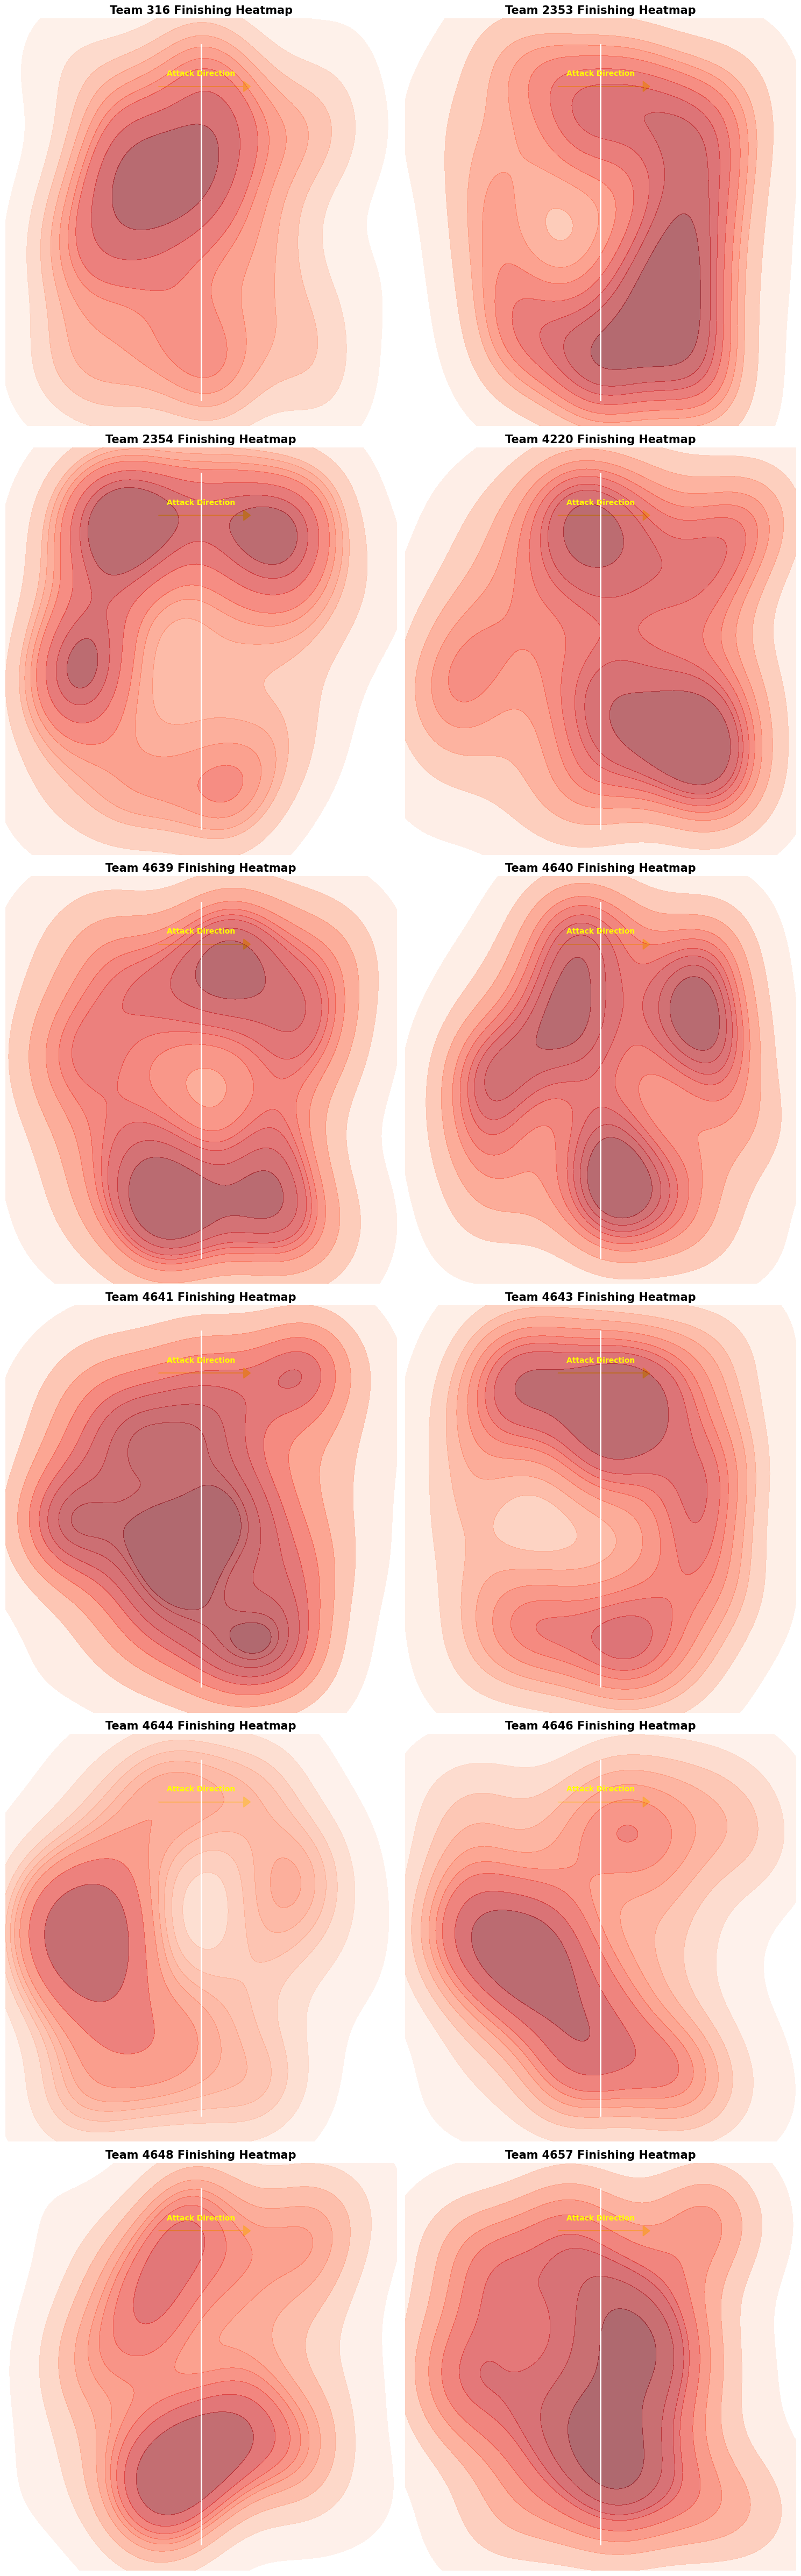

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# 1. 축구장 그리기 함수 (재사용)
def draw_pitch(ax):
    # 경기장 배경 (잔디색)
    ax.set_facecolor('#247d28')
    
    # 경기장 라인 (흰색)
    # 외곽선
    ax.add_patch(patches.Rectangle((0, 0), 105, 68, fill=False, edgecolor='white', linewidth=2))
    # 중앙선
    ax.plot([52.5, 52.5], [0, 68], color='white', linewidth=2)
    # 센터 서클
    ax.add_patch(patches.Circle((52.5, 34), 9.15, fill=False, edgecolor='white', linewidth=2))
    ax.add_patch(patches.Circle((52.5, 34), 0.5, fill=True, color='white'))
    
    # 페널티 박스 (16.5m)
    ax.add_patch(patches.Rectangle((0, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    ax.add_patch(patches.Rectangle((105-16.5, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    
    # 골대
    ax.add_patch(patches.Rectangle((-2, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))

    # 공격 방향 표시 (L -> R)
    ax.arrow(40, 60, 25, 0, head_width=2, head_length=2, fc='yellow', ec='yellow', alpha=0.7)
    ax.text(52.5, 62, "Attack Direction", color='yellow', ha='center', fontsize=10, fontweight='bold')

# 2. 에피소드 마지막 위치 데이터 준비
# (이미 위에서 episode_finish_stats를 만드셨다면 이 부분은 생략 가능합니다)
episode_finish_stats = train.groupby(['team_id', 'episode_id']).agg(
    finish_x=('start_x', 'last'),
    finish_y=('start_y', 'last')
).reset_index()

# 3. 히트맵 시각화 (상위 6개 팀 예시)
unique_teams = episode_finish_stats['team_id'].unique()
target_teams = unique_teams

# Subplot 설정
cols = 2
rows = (len(target_teams) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 8))
axes = axes.flatten()

for i, team_id in enumerate(target_teams):
    ax = axes[i]
    
    # 3-1. 경기장 그리기
    draw_pitch(ax)
    
    # 3-2. 해당 팀의 마무리 위치 데이터 필터링
    team_data = episode_finish_stats[episode_finish_stats['team_id'] == team_id]
    
    # 3-3. 히트맵(KDE Plot) 그리기
    # x='finish_x', y='finish_y'를 사용합니다.
    sns.kdeplot(
        data=team_data,
        x='finish_x',
        y='finish_y',
        fill=True,
        cmap='Reds',       # 마무리 위치는 붉은색 계열로 강조
        thresh=0.05,       # 노이즈 제거
        alpha=0.6,         # 투명도
        levels=10,
        ax=ax
    )
    
    # 3-4. 그래프 꾸미기
    ax.set_title(f"Team {team_id} Finishing Heatmap", fontsize=15, fontweight='bold', color='black')
    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.axis('off')

# 남는 subplot 숨기기
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

=== 팀별/홈원정별 에피소드 마지막 위치(Finishing) 분석 ===
   team_id  is_home  mean_finish_x  mean_finish_y       Left     Center  \
0      316    False      50.603102      35.099232  28.703704  32.407407   
1      316     True      50.754524      34.353052  31.775701  34.579439   
2     2353    False      56.332553      32.408032  37.614679  27.522936   
3     2353     True      54.193375      32.218119  36.607143  33.035714   
4     2354    False      47.328901      35.762734  27.659574  36.170213   

       Right        label  
0  38.888889   316 (Away)  
1  33.644860   316 (Home)  
2  34.862385  2353 (Away)  
3  30.357143  2353 (Home)  
4  36.170213  2354 (Away)  


<Figure size 1400x600 with 0 Axes>

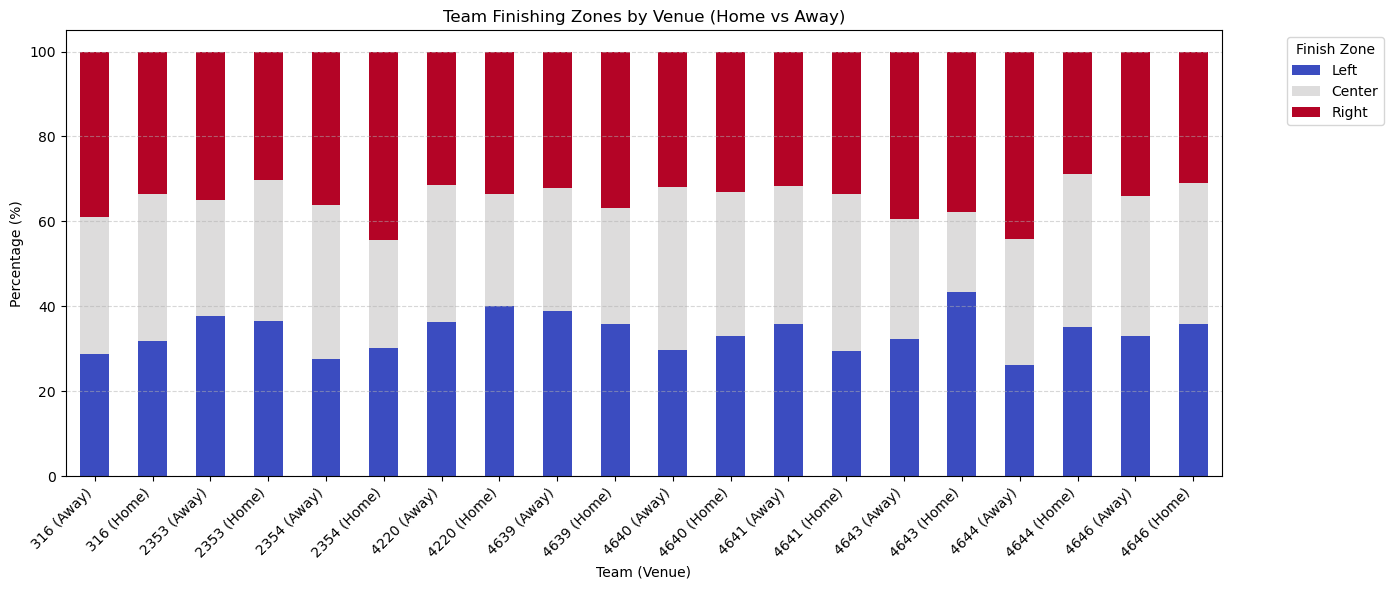

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 (생략 가능)
# train = pd.read_csv("./data/train.csv")

# 2. 에피소드별 '마지막' 위치 데이터 추출 (is_home 추가)
# team_id와 함께 is_home을 그룹화 키로 사용하여 홈/원정 상태를 유지합니다.
episode_finish_stats = train.groupby(['team_id', 'is_home', 'episode_id']).agg(
    finish_x=('start_x', 'last'),  # 마지막 이벤트의 시작 X좌표 (마무리 위치)
    finish_y=('start_y', 'last')   # 마지막 이벤트의 시작 Y좌표
).reset_index()

# 3. 마무리 위치(Zone) 분류 (경기장 폭 68m 기준)
def classify_zone(y):
    if y < 22.67: return 'Left'
    elif y < 45.33: return 'Center'
    else: return 'Right'

episode_finish_stats['zone'] = episode_finish_stats['finish_y'].apply(classify_zone)

# 4. 팀별 & 홈/원정별 통계 집계
# 4-1. 평균 마무리 위치 (groupby에 is_home 포함)
team_finish_stats = episode_finish_stats.groupby(['team_id', 'is_home']).agg(
    mean_finish_x=('finish_x', 'mean'),  # 평균 종료 X 위치
    mean_finish_y=('finish_y', 'mean')   # 평균 종료 Y 위치
)

# 4-2. 마무리 구역 비율 (인덱스에 is_home 포함)
finish_zone_ratios = pd.crosstab(
    [episode_finish_stats['team_id'], episode_finish_stats['is_home']], 
    episode_finish_stats['zone'], 
    normalize='index'
) * 100

# 컬럼 강제 정렬 및 결측치 0 처리
finish_zone_ratios = finish_zone_ratios.reindex(columns=['Left', 'Center', 'Right'], fill_value=0)

# 5. 최종 데이터 병합
final_finish_analysis = pd.merge(team_finish_stats, finish_zone_ratios, left_index=True, right_index=True).reset_index()

# 시각화 라벨 생성 (Team + Venue)
final_finish_analysis['label'] = final_finish_analysis.apply(
    lambda x: f"{x['team_id']} ({'Home' if x['is_home'] else 'Away'})", axis=1
)

print("=== 팀별/홈원정별 에피소드 마지막 위치(Finishing) 분석 ===")
print(final_finish_analysis.head())

# 6. 시각화
# 6-1. 팀별 공격 마무리 구역 비율 (Stacked Bar Chart)
plt.figure(figsize=(14, 6))

# 데이터가 너무 많으면 상위 20개만 시각화 (선택 사항)
plot_data = final_finish_analysis.set_index('label')[['Left', 'Center', 'Right']]
if len(plot_data) > 20:
    plot_data = plot_data.head(20)

plot_data.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 6))

plt.title("Team Finishing Zones by Venue (Home vs Away)")
plt.ylabel("Percentage (%)")
plt.xlabel("Team (Venue)")
plt.legend(title='Finish Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

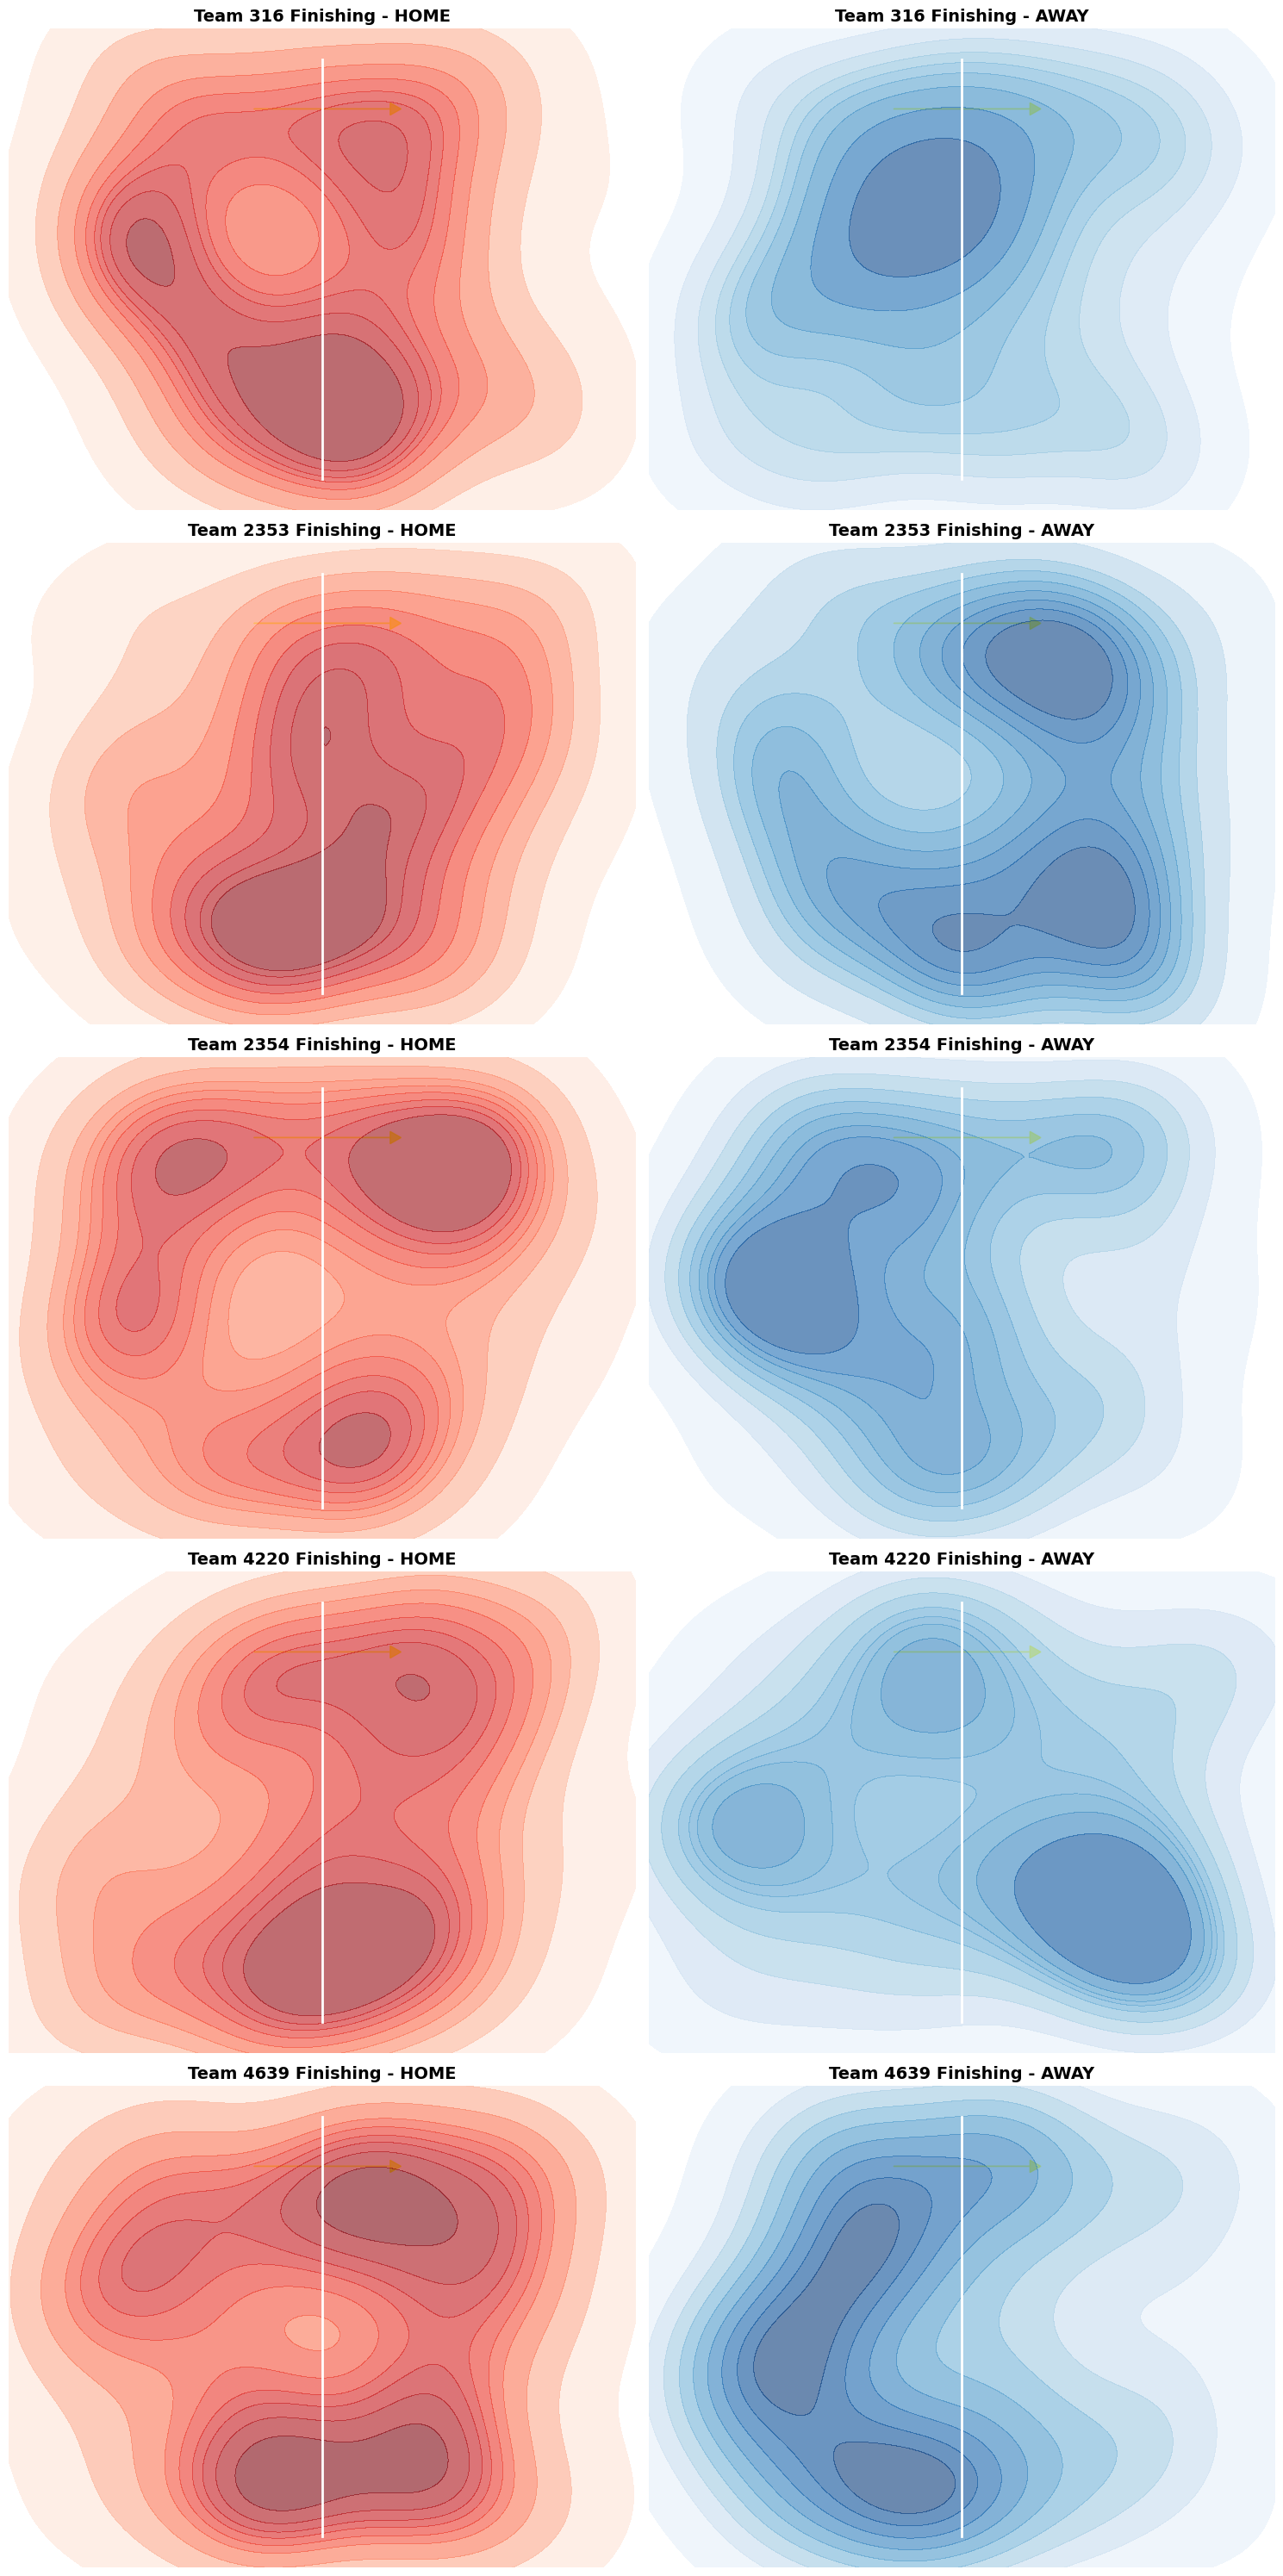

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# 1. 축구장 그리기 함수 (재사용)
def draw_pitch(ax):
    # 경기장 배경 (잔디색)
    ax.set_facecolor('#247d28')
    
    # 경기장 라인 (흰색)
    ax.add_patch(patches.Rectangle((0, 0), 105, 68, fill=False, edgecolor='white', linewidth=2))
    ax.plot([52.5, 52.5], [0, 68], color='white', linewidth=2)
    ax.add_patch(patches.Circle((52.5, 34), 9.15, fill=False, edgecolor='white', linewidth=2))
    ax.add_patch(patches.Circle((52.5, 34), 0.5, fill=True, color='white'))
    
    # 페널티 박스 (16.5m)
    ax.add_patch(patches.Rectangle((0, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    ax.add_patch(patches.Rectangle((105-16.5, 13.84), 16.5, 40.32, fill=False, edgecolor='white', linewidth=2))
    
    # 골대
    ax.add_patch(patches.Rectangle((-2, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))
    ax.add_patch(patches.Rectangle((105, 30.34), 2, 7.32, fill=True, color='white', alpha=0.3))

    # 공격 방향 표시 (L -> R)
    ax.arrow(40, 60, 25, 0, head_width=2, head_length=2, fc='yellow', ec='yellow', alpha=0.7)

# 2. 에피소드 마지막 위치 데이터 준비 (is_home 추가)
# team_id와 is_home을 모두 그룹화 키로 사용하여 분리
episode_finish_stats = train.groupby(['team_id', 'is_home', 'episode_id']).agg(
    finish_x=('start_x', 'last'),
    finish_y=('start_y', 'last')
).reset_index()

# 3. 히트맵 시각화
unique_teams = sorted(episode_finish_stats['team_id'].unique())
target_teams = unique_teams[:5] # 예시: 상위 5개 팀만 (전체 확인 시 슬라이싱 제거)

# Layout 설정: 행(팀 수) x 열(2개: Home/Away)
rows = len(target_teams)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 6))

# 팀이 1개일 경우 axes가 1차원 배열이 되므로 2차원으로 변환 처리
if rows == 1:
    axes = axes.reshape(1, -1)

for i, team_id in enumerate(target_teams):
    # 홈(True) -> 원정(False) 순서로 반복
    for j, is_home in enumerate([True, False]):
        ax = axes[i, j]
        
        # 3-1. 경기장 그리기
        draw_pitch(ax)
        
        # 3-2. 데이터 필터링 (팀 AND 홈/원정)
        team_data = episode_finish_stats[
            (episode_finish_stats['team_id'] == team_id) & 
            (episode_finish_stats['is_home'] == is_home)
        ]
        
        # 3-3. 히트맵 그리기 (데이터가 있을 경우에만)
        if not team_data.empty:
            # 색상 구분: 홈(Red), 원정(Blue)
            cmap_color = 'Reds' if is_home else 'Blues'
            
            sns.kdeplot(
                data=team_data,
                x='finish_x',
                y='finish_y',
                fill=True,
                cmap=cmap_color,
                thresh=0.05,       # 노이즈 제거
                alpha=0.6,         # 투명도
                levels=10,
                ax=ax
            )
        
        # 3-4. 그래프 꾸미기
        venue_text = "HOME" if is_home else "AWAY"
        ax.set_title(f"Team {team_id} Finishing - {venue_text}", fontsize=14, fontweight='bold', color='black')
        ax.set_xlim(-5, 110)
        ax.set_ylim(-5, 73)
        ax.axis('off')

plt.tight_layout()
plt.show()